In [ ]:
# !pip install -U datasets

In [ ]:
!pip install Levenshtein

# Setup

## Imports, Load Sampled MJSynth, Setup Drive and Wandb

In [ ]:
import os
import random
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import wandb

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import CosineAnnealingLR

import Levenshtein
from Levenshtein import distance as levenshtein_distance

from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score
from tqdm import tqdm
from difflib import SequenceMatcher
from itertools import groupby
from datasets import load_dataset
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configs

In [ ]:
num_images = 20000
model_selected = 1  # 1: Encoder: CNN + Decoder: GRU -> Attention
                    # 2: Encoder: CNN + Decoder: Attention -> GRU
                    # 3: Encoder: CNN + Decoder: Transformer

## Utility Functions

In [ ]:
# === Transformer Masking ===
def generate_square_subsequent_mask(sz, device=None):
    """
    Creates an upper-triangular matrix filled with -inf (masked), used for autoregressive decoding.
    Unmasked elements are 0.0.
    Used to prevent the decoder from attending to future positions.
    """
    return torch.triu(torch.full((sz, sz), float('-inf'), device=device), diagonal=1)


# === Sequence Decoding Utilities ===
def decode_sequence(sequence, inv_vocab, eos_token="<EOS>", skip_tokens={"<SOS>", "<PAD>"}):
    """
    Decodes a single token sequence to string, stopping at <EOS> and skipping control tokens.
    """
    chars = []
    for idx in sequence:
        token = inv_vocab.get(idx.item() if isinstance(idx, torch.Tensor) else idx, "")
        if token == eos_token:
            break
        if token not in skip_tokens:
            chars.append(token)
    return ''.join(chars)


def decode_ground_truth(label_tensor, inv_vocab, sos_token="<SOS>", eos_token="<EOS>", pad_token="<PAD>"):
    """
    Decodes a ground truth label tensor into readable text.
    Skips padding and special tokens.
    """
    chars = []
    for idx in label_tensor:
        char = inv_vocab.get(idx.item(), "")
        if char in [sos_token, pad_token]:
            continue
        if char == eos_token:
            break
        chars.append(char)
    return ''.join(chars)


def decode_label(tensor_label, char_list):
    """
    Simple decode of a tensor label using index lookup.
    Removes special tokens like <PAD>, <SOS>, <EOS>.
    """
    special_tokens = {"<PAD>", "<SOS>", "<EOS>"}
    return ''.join(
        c for i in tensor_label.tolist()
        if (c := char_list[i]) not in special_tokens
    )

# Utility function: Computes normalized edit distance between two strings as a similarity metric
def compute_edit_distance(pred, gt):
    return 1 - SequenceMatcher(None, pred, gt).ratio()


# Utility function: Calculates character-level accuracy across all predictions
def character_accuracy(preds, gts):
    """
    Returns the proportion of correctly predicted characters over all ground truths.
    """
    correct, total = 0, 0
    for p, g in zip(preds, gts):
        m = min(len(p), len(g))
        correct += sum(p[i] == g[i] for i in range(m))
        total += len(g)
    return correct / total if total else 0


# Utility function: Calculates word-level accuracy (exact match) across all predictions
def word_accuracy(preds, gts):
    """
    Returns the proportion of completely correct word predictions.
    """
    correct = sum(p == g for p, g in zip(preds, gts))
    return correct / len(gts) if gts else 0


def visualize_predictions(encoder, decoder, dataset, token2idx, num_samples):
    """
    Visualizes model predictions for a few random samples from the dataset.
    Displays GT vs Prediction for each image, plus accuracy metrics.
    """
    if isinstance(token2idx, list):
        token2idx = {token: idx for idx, token in enumerate(token2idx)}

    inv_vocab = {idx: char for char, idx in token2idx.items()}
    sos_token_idx = token2idx.get("<SOS>", 0)
    eos_token_idx = token2idx.get("<EOS>", -1)

    encoder.eval()
    decoder.eval()

    dataloader = DataLoader(dataset, batch_size=num_samples, shuffle=True, collate_fn=collate_fn_wrapper(dataset))

    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    batch_size = images.size(0)

    with torch.no_grad():
        encoder_outputs = encoder(images)

        is_transformer = model_selected in [3]

        # Initialize decoder input with <SOS> token
        decoder_input = torch.full(
            (batch_size, 1) if is_transformer else (batch_size,),
            sos_token_idx,
            dtype=torch.long,
            device=device
        )

        decoder_hidden = None
        decoded_sequences = [[] for _ in range(batch_size)]
        finished = [False] * batch_size
        max_length = labels.size(1) + 10  # Safety margin

        for _ in range(max_length):
            if is_transformer:
                tgt_mask = generate_square_subsequent_mask(decoder_input.size(1), device=device)
                decoder_output = decoder(decoder_input, encoder_outputs, tgt_mask=tgt_mask)
            else:
                decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)

            _, topi = decoder_output.topk(1)
            predicted_token = topi.view(-1)

            for i in range(batch_size):
                if not finished[i]:
                    token_id = predicted_token[i].item()
                    decoded_sequences[i].append(token_id)
                    if token_id == eos_token_idx:
                        finished[i] = True

            if all(finished):
                break

            decoder_input = predicted_token.detach().unsqueeze(1) if is_transformer else predicted_token.detach()

        decoded_texts = [decode_sequence(seq, inv_vocab) for seq in decoded_sequences]
        gt_texts = [decode_ground_truth(lbl, inv_vocab) for lbl in labels]

    # Plot results
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img_np = images[i].cpu().squeeze().numpy()
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"GT: {gt_texts[i]}\nPred: {decoded_texts[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print metrics
    char_acc = character_accuracy(decoded_texts, gt_texts)
    word_acc = word_accuracy(decoded_texts, gt_texts)
    print(f"Evaluation on Sample:")
    print(f"Character-level Accuracy: {char_acc:.4f}")
    print(f"Word-level Accuracy:      {word_acc:.4f}")



# Utility function: Counts total number of trainable parameters in the model for model size evaluation
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Utility function: Computes Character Error Rate (CER) as total edit distance normalized by total GT characters
def character_error_rate(preds, gts):
    total_edits, total_chars = 0, 0
    for p, g in zip(preds, gts):
        total_edits += levenshtein_distance(p, g)
        total_chars += len(g)
    return total_edits / total_chars if total_chars else 0


# Utility function: Computes word-level accuracy allowing up to k character differences (edit distance tolerance)
def word_accuracy_at_k(preds, gts, k):
    correct = sum(levenshtein_distance(p, g) <= k for p, g in zip(preds, gts))
    return correct / len(gts) if gts else 0


## Load Dataset

In [ ]:
# Load MJSynth dataset (non-streaming)
ds = load_dataset("priyank-m/MJSynth_text_recognition", split="train")

# Shuffle and select num_images samples
sampled = ds.shuffle(seed=42).select(range(num_images))
assert len(sampled) == num_images, f"Sampled {len(sampled)} images, expected {num_images}"

# Define output paths with versioning
base_dir = "/content/drive/MyDrive/mjsynth_sampled"
images_dir = os.path.join(base_dir, "images")
os.makedirs(images_dir, exist_ok=True)

label_txt_path = os.path.join(base_dir, f"label_{num_images}.txt")

# Save sampled images and label file
with open(label_txt_path, "w") as f:
    for idx, item in enumerate(sampled):
        image: Image.Image = item['image']
        label = item['label']

        filename = f"img_{idx:05d}.jpg"
        full_img_path = os.path.join(images_dir, filename)
        relative_path = os.path.relpath(full_img_path, base_dir)

        if not os.path.exists(full_img_path):
            image.save(full_img_path)

        f.write(f"{relative_path}\t{label}\n")

# Pre - Processing

In [ ]:
class TextRecognitionDataset(Dataset):
    """
    Purpose:
        Read image paths and corresponding text labels from a text file (label.txt)
        Load and transform the image
        Encode the text label into a sequence of integers
        Provide the image and encoded label to the model during training or evaluation
    """
    def __init__(self, label_file, transform=None, char_list=None, max_label_len=None):
        """
        Args:
            label_file: Path to label.txt (format: img_path \t label)
            transform: torchvision transforms to apply to image
            char_list: character vocabulary (sorted list of unique characters)
            max_label_len: max length for label padding
        """
        self.samples = pd.read_csv(label_file, sep="\t", names=["img_path", "label"])
        self.samples.dropna(inplace=True)  # Drop rows where label is NaN

        self.transform = transform
        self.label_file = label_file

        # Build vocabulary if not provided
        if char_list is None:
            all_text = "".join(self.samples["label"])
            base_chars = sorted(set(all_text))
        else:
            base_chars = char_list

        # Ensure special tokens are at the start of the vocabulary
        special_tokens = ["<PAD>", "<SOS>", "<EOS>"]
        for token in reversed(special_tokens):  # insert reversed to maintain order
            if token not in base_chars:
                base_chars.insert(0, token)

        self.char_list = base_chars

        # Set max label length (without special tokens)
        self.max_label_len = max_label_len or self.samples["label"].str.len().max()

        # Pre-encode labels
        self.encoded_labels = self.samples["label"].apply(self.encode_label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples.iloc[idx]["img_path"]
        label = self.encoded_labels.iloc[idx]

        image_path = os.path.join(os.path.dirname(self.label_file), img_path)

        assert os.path.exists(image_path), f"{image_path} not found"

        image = Image.open(image_path).convert("L")

        if self.transform:
            image = self.transform(image)

        return image, label

    def encode_label(self, text):
        sos_idx = self.char_list.index("<SOS>")
        eos_idx = self.char_list.index("<EOS>")
        pad_idx = self.char_list.index("<PAD>")

        label = [self.char_list.index(c) for c in text]
        label = [sos_idx] + label + [eos_idx]

        # Pad to fixed length (max_label_len + 2 for SOS and EOS)
        max_len = self.max_label_len + 2
        label += [pad_idx] * (max_len - len(label))

        return label

    def decode_label(self, encoded):
        """
        Decodifica una lista de índices en una cadena de texto (excluye tokens especiales).
        """
        pad_idx = self.char_list.index("<PAD>")
        sos_idx = self.char_list.index("<SOS>")
        eos_idx = self.char_list.index("<EOS>")

        chars = []
        for idx in encoded:
            if idx in (pad_idx, sos_idx):  # Ignora PAD y SOS
                continue
            if idx == eos_idx:
                break
            chars.append(self.char_list[idx])
        return ''.join(chars)


    def get_vocab(self):
        return self.char_list

    def get_max_label_len(self):
        return self.max_label_len

    def custom_collate_fn(self, batch):
        images, labels = zip(*batch)
        images = torch.stack(images, dim=0)
        pad_idx = self.char_list.index("<PAD>")
        labels = [torch.tensor(lbl, dtype=torch.long) for lbl in labels]
        labels = pad_sequence(labels, batch_first=True, padding_value=pad_idx)
        return images, labels

# Data Loader

In [ ]:
def collate_fn_wrapper(dataset):
        def collate_fn(batch):
            return dataset.custom_collate_fn(batch)
        return collate_fn

# Define image transformations to ensure same image size #### WITH NORMALIZATION?
transform = transforms.Compose([
    transforms.Resize((32, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
label_file = f"/content/drive/MyDrive/mjsynth_sampled/label_{num_images}.txt"
dataset = TextRecognitionDataset(label_file, transform=transform)

# Create DataLoader with your custom collate_fn from dataset instance
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn_wrapper(dataset))

# === Add special tokens to vocabulary ===
special_tokens = ["<PAD>", "<SOS>", "<EOS>"]  # Padding, Start-of-Sequence, End-of-Sequence tokens

# Merge special tokens with actual vocabulary, making sure to exclude duplicates
vocab_list = special_tokens + [c for c in dataset.get_vocab() if c not in special_tokens]

# Create mappings from token to index and vice versa
token2idx = {token: idx for idx, token in enumerate(vocab_list)}
idx2token = {idx: token for token, idx in token2idx.items()}

vocab_size = len(token2idx)  # Total vocabulary size

# Example sample
image, label = dataset[0]
print(image.shape)
print(label)  # Should print the padded encoded label


torch.Size([1, 32, 128])
[1, 15, 27, 33, 26, 32, 17, 30, 32, 17, 26, 27, 30, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Example image and its label

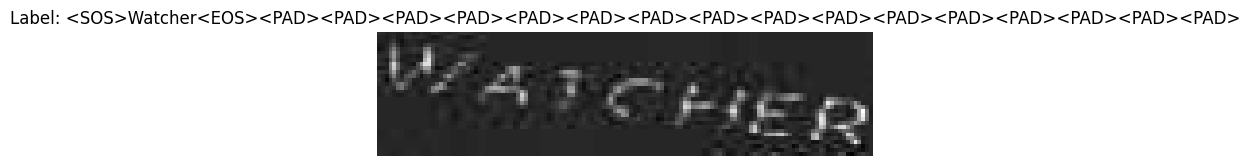

In [ ]:
# Get a sample
image_tensor, encoded_label = dataset[3]  # You can change the index here (e.g., dataset[10])

# Convert tensor to image (CHW to HWC)
image_np = image_tensor.squeeze().numpy()  # Shape: [32, 128] for grayscale

# Decode the label from indices to characters
vocab = dataset.get_vocab()
pad_token = vocab.index("<PAD>")

# Remove padding tokens and decode
decoded_label = ''.join([vocab[i] for i in encoded_label]) # if i != pad_token])

# Show the image
plt.imshow(image_np, cmap='gray')
plt.title(f"Label: {decoded_label}")
plt.axis('off')
plt.show()


## Train-Test split

In [ ]:
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn_wrapper(dataset)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn_wrapper(dataset)
)

# Model architectures

## Encoder

### CNN

In [ ]:
# === Encoder: CNN with skip connections and progressive downsampling ===
class Encoder_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Block 1: Conv + ReLU + MaxPool
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 2: Conv + ReLU + MaxPool
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 3: Conv + BatchNorm + ReLU
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Skip connection from block2 to block3
        self.skip23 = nn.Conv2d(128, 256, kernel_size=1)

        # Block 4: Conv + ReLU + MaxPool (with (2,1) to retain width info)
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1))
        )

        # Block 5: Conv + BatchNorm + ReLU + MaxPool
        self.block5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1))
        )

        # Skip connection from block4 to block5
        self.skip45 = nn.Conv2d(256, 512, kernel_size=1)

        # Final conv layer to flatten height dimension
        self.final_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(2, 1)),
            nn.ReLU()
        )

    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1)

        x3 = self.block3(x2)
        skip_x2 = self.skip23(x2)
        x3 = x3 + F.interpolate(skip_x2, size=x3.shape[2:], mode='nearest')

        x4 = self.block4(x3)

        x5 = self.block5(x4)
        skip_x4 = self.skip45(x4)
        x5 = x5 + F.interpolate(skip_x4, size=x5.shape[2:], mode='nearest')

        x = self.final_conv(x5)  # [B, 512, H=1, W]
        x = x.squeeze(2)         # [B, 512, W]
        x = x.permute(0, 2, 1)   # [B, W, 512] - sequence of W steps with 512-dim features
        return x

## Decoder

### Option 1: GRU -> Attention

In [ ]:
# === Decoder: GRU -> Attention ===
class Decoder_GRU_Attention(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

        # Scaled Dot-Product Attention
        self.attn = nn.MultiheadAttention(hidden_size, num_heads=1, batch_first=True)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_token, hidden, encoder_outputs):
        embedded = self.embedding(input_token).unsqueeze(1)  # [B, 1, H]
        embedded = self.dropout(embedded)

        gru_output, hidden = self.gru(embedded, hidden)  # [B, 1, H]
        context, attn_weights = self.attn(gru_output, encoder_outputs, encoder_outputs)  # [B, 1, H]

        combined = torch.cat((gru_output, context), dim=2)  # [B, 1, 2H]
        combined = self.attn_combine(combined)              # [B, 1, H]
        output = self.out(combined)                         # [B, 1, V]
        return output.squeeze(1), hidden, attn_weights

### Option 2: Attention -> GRU

In [ ]:
# === Decoder: Attention -> GRU ===
class Decoder_Attention_GRU(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)

        # Multi-head attention before feeding into GRU
        self.attn = nn.MultiheadAttention(hidden_size, num_heads=1, batch_first=True)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_token, hidden, encoder_outputs):
        embedded = self.embedding(input_token).unsqueeze(1)  # [B, 1, H]
        embedded = self.dropout(embedded)

        # Attention: query = embedded, key/value = encoder_outputs
        context, attn_weights = self.attn(embedded, encoder_outputs, encoder_outputs)  # [B, 1, H]

        # Feed attended context to GRU
        output, hidden = self.gru(context, hidden)
        output = self.out(output)  # [B, 1, V]
        return output.squeeze(1), hidden, attn_weights

### Option 3: TransformerDecoder

In [ ]:
# === Transformer Decoder: with learnable positional encoding (properly initialized) ===
class Transformer_Decoder(nn.Module):
    def __init__(self, vocab_size, hidden_dim=512, nhead=8, num_layers=3, dropout=0.1, max_len=500):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        # === FIX: Learnable positional encodings are now properly initialized ===
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, hidden_dim))  # [1, T, H]
        nn.init.normal_(self.positional_encoding, mean=0.0, std=0.02)  # 💡 Proper init instead of zeros

        self.dropout = nn.Dropout(dropout)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_dim, nhead=nhead, dim_feedforward=2048, dropout=dropout, batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, tgt_tokens, memory, tgt_mask=None, memory_mask=None):
        B, T_out = tgt_tokens.shape

        # Embedding + Positional Encoding + Dropout
        x = self.embedding(tgt_tokens)                          # [B, T, H]
        x = x + self.positional_encoding[:, :T_out, :]         # 💡 Add positional encoding
        x = self.dropout(x)

        # Transformer decoder expects (B, T, H); tgt_mask must be causal
        output = self.transformer_decoder(
            tgt=x,
            memory=memory,
            tgt_mask=tgt_mask,
            memory_mask=memory_mask
        )

        output = self.fc_out(output)  # [B, T, V]
        return output

# Training

In [ ]:
# === Set up wandb run name and architecture string ===
if model_selected == 1:
    architecture = "Encoder: CNN + Decoder: GRU with Attention"
    wandb_name = f"Seq2Seq: CNN-GRU-Attention-{num_images}_imgs"
elif model_selected == 2:
    architecture = "Encoder: CNN + Decoder: Attention then GRU"
    wandb_name = f"Seq2Seq: CNN-Attention-GRU-{num_images}_imgs"
elif model_selected == 3:
    architecture = "Encoder: CNN + Decoder: Transformer"
    wandb_name = f"Seq2Seq: CNN-Transformer-{num_images}_imgs"

# === wandb config ===
config = {
    "epochs":15,
    "batch_size": 32,
    "learning_rate":  0.001,
    "architecture": architecture
}
wandb.init(project="OCR", name=wandb_name)

## Loss function and optimizer

In [ ]:
# === Instantiate encoder and decoder based on model choice ===
if model_selected == 1:
    # Baseline: CNN encoder with GRU + additive attention decoder
    encoder = Encoder_CNN().to(device)
    decoder = Decoder_GRU_Attention(hidden_size=512, output_size=vocab_size).to(device)
elif model_selected == 2:
    # Variant: CNN encoder + attention-first decoder with GRU
    encoder = Encoder_CNN().to(device)
    decoder = Decoder_Attention_GRU(hidden_size=512, output_size=vocab_size).to(device)
elif model_selected == 3:
    # Transformer-based decoder over CNN encoder
    encoder = Encoder_CNN().to(device)
    decoder = Transformer_Decoder(
        vocab_size=vocab_size,
        hidden_dim=512,
        nhead=8,
        num_layers=3,
        dropout=0.1,
        max_len=500
    ).to(device)

# === Loss Function ===
# Using CrossEntropyLoss, which expects class indices.
# No padding ignored here by default — consider `ignore_index=token2idx["<PAD>"]` for padding.
criterion = nn.CrossEntropyLoss(ignore_index=token2idx["<PAD>"])

# === Optimizer ===
# Combine encoder and decoder parameters for joint optimization
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

# Define learning rate scheduler to reduce LR every 5 epochs by factor 0.5 for stable convergence
scheduler = CosineAnnealingLR(optimizer, T_max=config["epochs"])

## Train one epoch

In [ ]:
def train_one_epoch_attention(encoder, decoder, dataloader, optimizer, criterion, vocab, max_len=32):
    encoder.train()
    decoder.train()
    epoch_loss = 0

    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        batch_size = imgs.size(0)

        optimizer.zero_grad()

        # === Forward pass ===
        encoder_outputs = encoder(imgs)  # shape: [B, T_enc, H]
        decoder_input = torch.full((batch_size,), vocab["<SOS>"], dtype=torch.long, device=device)
        decoder_hidden = None
        loss = 0

        # Teacher forcing: feed ground-truth label at each timestep
        for t in range(labels.size(1)):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, labels[:, t])

            # Teacher forcing decay
            teacher_forcing_ratio = max(0.5, 1.0 - epoch * 0.1)  # Ejemplo: empieza en 1.0 y baja 0.1 por epoch

            use_teacher_forcing = random.random() < teacher_forcing_ratio

            if use_teacher_forcing:
                decoder_input = labels[:, t]  # ground truth
            else:
                top1 = decoder_output.argmax(1)
                decoder_input = top1.detach()  # model prediction

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() / labels.size(1)  # Normalize by sequence length

    avg_loss = epoch_loss / len(dataloader)
    wandb.log({"Train Loss": avg_loss})
    return avg_loss



def train_one_epoch_transformer(encoder, decoder, dataloader, optimizer, criterion, vocab, max_len=32):
    encoder.train()
    decoder.train()
    epoch_loss = 0

    pad_idx = vocab.get("<PAD>", None)  # <-- FIX here

    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        batch_size = imgs.size(0)
        optimizer.zero_grad()

        encoder_outputs = encoder(imgs)

        tgt_input = labels[:, :-1]
        tgt_output = labels[:, 1:]
        tgt_seq_len = tgt_input.size(1)

        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).to(device)

        output = decoder(tgt_input, memory=encoder_outputs, tgt_mask=tgt_mask)

        output = output.reshape(-1, output.size(-1))
        tgt_output = tgt_output.reshape(-1)

        if pad_idx is not None and hasattr(criterion, 'ignore_index'):
            criterion.ignore_index = pad_idx

        loss = criterion(output, tgt_output)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    wandb.log({"Train Loss": avg_loss})
    return avg_loss

## Sanity-check before training

In [ ]:
############## Validations

for i in range(5):
    img, label = dataset[i]
    print(f"Sample {i}: image shape={img.shape}, label indices={label}")
    print(f"Decoded label: {[idx2token[idx] for idx in label]}") # if idx != token2idx['<PAD>']]}")

Sample 0: image shape=torch.Size([1, 32, 128]), label indices=[1, 15, 27, 33, 26, 32, 17, 30, 32, 17, 26, 27, 30, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded label: ['<SOS>', 'C', 'O', 'U', 'N', 'T', 'E', 'R', 'T', 'E', 'N', 'O', 'R', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Sample 1: image shape=torch.Size([1, 32, 128]), label indices=[1, 28, 56, 47, 51, 39, 41, 63, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded label: ['<SOS>', 'P', 'r', 'i', 'm', 'a', 'c', 'y', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Sample 2: image shape=torch.Size([1, 32, 128]), label indices=[1, 18, 59, 58, 59, 56, 53, 50, 53, 45, 63, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded label: ['<SOS>', 'F', 'u', 't', 'u', 'r', 'o', 'l', 'o', 'g', 'y', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PA

In [ ]:
for imgs, labels in train_loader:
    print("Labels max value:", labels.max().item())
    print("Vocab size:", vocab_size)
    assert labels.max().item() < vocab_size, "Labels out of vocabulary range"
    break

NameError: name 'train_loader' is not defined

## Training Loop

In [ ]:
best_loss = float('inf')

# === Training loop ===
for epoch in range(config["epochs"]):
    print(f"\nEpoch {epoch + 1}/{config['epochs']}")

    if model_selected in [1, 2]:
        train_loss = train_one_epoch_attention(encoder, decoder, train_loader, optimizer, criterion, token2idx)
    else:  # Transformer decoder
        train_loss = train_one_epoch_transformer(encoder, decoder, train_loader, optimizer, criterion, token2idx)

    print(f"Train Loss: {train_loss:.4f}")

    # === Validation ===
    encoder.eval()
    decoder.eval()
    val_loss = 0
    all_preds = []
    all_gts = []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            batch_size = imgs.size(0)

            encoder_outputs = encoder(imgs)

            if model_selected in [1, 2]:  # GRU variants
                decoder_input = torch.full((batch_size,), token2idx["<SOS>"], dtype=torch.long, device=device)
                decoder_hidden = None

                preds_batch = []
                for t in range(labels.size(1)):
                    decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
                    val_loss += criterion(decoder_output, labels[:, t]).item()

                    # Get top-1 prediction
                    top1 = decoder_output.argmax(1)
                    preds_batch.append(top1)

                    top1 = decoder_output.argmax(1)
                    decoder_input = top1.detach()


                # Convert predicted token IDs to strings
                preds_batch = torch.stack(preds_batch, dim=1)  # [B, T]
                preds_strs = [decode_sequence(seq, idx2token) for seq in preds_batch]
                gts_strs = [decode_sequence(seq, idx2token) for seq in labels]


                all_preds.extend(preds_strs)
                all_gts.extend(gts_strs)

            else:  # Transformer decoder

                batch_size = imgs.size(0)
                max_length = labels.size(1) + 10  # Safety margin

                # === Inference decoding (greedy autoregressive) ===
                decoded_sequences = [[] for _ in range(batch_size)]

                # Initialize decoder input with <SOS> token
                decoder_input = torch.full(
                    (batch_size, 1),
                    token2idx["<SOS>"],
                    dtype=torch.long,
                    device=device
                )

                for _ in range(max_length):
                    tgt_mask = generate_square_subsequent_mask(decoder_input.size(1), device=device)

                    # Forward pass through transformer decoder
                    output = decoder(
                        decoder_input,
                        memory=encoder_outputs,
                        tgt_mask=tgt_mask
                    )  # [B, T, V]

                    # Get last timestep predictions (greedy decoding)
                    next_token_logits = output[:, -1, :]  # [B, V]
                    next_token = next_token_logits.argmax(dim=-1, keepdim=True)  # [B, 1]

                    # Append predicted tokens to sequences
                    for i in range(batch_size):
                        decoded_sequences[i].append(next_token[i].item())

                    # Concatenate next token to decoder input for next step
                    decoder_input = torch.cat([decoder_input, next_token], dim=1)

                    # Optional: stop if all sequences predicted <EOS>
                    # Uncomment if you want early stopping for efficiency
                    # if all(token2idx["<EOS>"] in seq for seq in decoded_sequences):
                    #     break

                # === Calculate loss using teacher forcing ===
                tgt_input = labels[:, :-1]
                tgt_output = labels[:, 1:]
                tgt_seq_len = tgt_input.size(1)
                tgt_mask = generate_square_subsequent_mask(tgt_seq_len).to(device)

                output = decoder(tgt_input, memory=encoder_outputs, tgt_mask=tgt_mask)
                output = output.reshape(-1, output.size(-1))
                tgt_output = tgt_output.reshape(-1)
                val_loss += criterion(output, tgt_output).item()

                # === Decode predictions and GTs to string ===
                preds_strs = [decode_sequence(seq, idx2token) for seq in decoded_sequences]
                gts_strs = [decode_sequence(seq, idx2token) for seq in labels]

                all_preds.extend(preds_strs)
                all_gts.extend(gts_strs)


    val_loss /= (len(val_loader) * labels.size(1))

    print(f"Val Loss: {val_loss:.4f}")

    # === Character Error Rate (CER) ===
    cer = character_error_rate(all_preds, all_gts)
    print(f"CER: {cer:.4f}")

    # === Word Accuracy@k ===
    acc_k_dict = {}
    for k in [0, 1, 2]:
        acc_k = word_accuracy_at_k(all_preds, all_gts, k)
        acc_k_dict[f"Word Accuracy @{k}"] = acc_k
        print(f"Word Accuracy @{k}: {acc_k:.4f}")

    # === Learning Rate Logging ===
    lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {lr:.6f}")

    # === Log to wandb ===
    wandb.log({
        "epoch": epoch + 1,
        "Train Loss": train_loss,
        "Val Loss": val_loss,
        "CER": cer,
        **acc_k_dict,
        "LR": lr,
    })

    # === Step the learning rate scheduler ===
    scheduler.step()

    # === Save best model ===
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save({
            "encoder": encoder.state_dict(),
            "decoder": decoder.state_dict(),
            "vocab": vocab,  # optional
        }, "OCR_seq_to_seq.pth")

# Inference & Evaluation

In [ ]:
visualize_predictions(encoder, decoder, dataset, token2idx, num_samples=10)

## Model Parameters

In [ ]:
encoder_params = count_parameters(encoder)
decoder_params = count_parameters(encoder)
total_params = encoder_params + decoder_params

print(f"Number of Encoder parameters: {encoder_params:,}")
print(f"Number of Decoder parameters: {decoder_params:,}")

wandb.log({"Num Params": total_params})

## Final Evaluation

### Token level metrics... word levels was as well

In [ ]:
def final_precision_recall_auc(encoder, decoder, val_loader, inv_vocab, token2idx):
    """
    Computes Precision-Recall curve and AUC for seq2seq model (per-sample evaluation),
    logs results to wandb, and saves the PR plot as an image artifact.
    """
    encoder.eval()
    decoder.eval()
    y_true, y_scores = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            batch_size = images.size(0)

            encoder_outputs = encoder(images)

            # Initialize decoder input (<SOS>)
            decoder_input = torch.full((batch_size,), token2idx["<SOS>"], dtype=torch.long, device=device)
            decoder_hidden = None
            preds_batch = []
            confidences_batch = []

            for t in range(labels.size(1)):
                decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)

                probs = torch.softmax(decoder_output, dim=1)
                top1 = probs.argmax(1)
                confidence = probs.max(1).values.cpu().numpy()

                preds_batch.append(top1)
                confidences_batch.append(confidence)

                decoder_input = top1  # Autoregressive decoding

            # Convert predictions to strings
            preds_batch = torch.stack(preds_batch, dim=1)
            preds_strs = [decode_sequence(seq, inv_vocab) for seq in preds_batch]
            gts_strs = [decode_ground_truth(seq, inv_vocab) for seq in labels]

            # Mean confidence per sample (per-sample evaluation)
            confidences_batch = np.stack(confidences_batch, axis=1)  # [B, T]
            mean_confidences = confidences_batch.mean(axis=1)

            sample_correctness = [int(p == g) for p, g in zip(preds_strs, gts_strs)]
            y_true.extend(sample_correctness)
            y_scores.extend(mean_confidences)

    # Compute PR curve and AUC
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    # Plot and save PR curve
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, marker='.', label=f'AUC={pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Seq2Seq)')
    plt.legend()
    plt.grid(True)

    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
        plt.savefig(tmpfile.name)
        wandb.log({"Precision-Recall Curve": wandb.Image(tmpfile.name)})
    plt.close()

    wandb.log({"Precision-Recall AUC": pr_auc})

    print(f"Final Precision-Recall AUC: {pr_auc:.4f}")
    return pr_auc


def final_roc_auc(encoder, decoder, val_loader, inv_vocab, token2idx):
    """
    Computes ROC AUC for seq2seq model (per-sample evaluation),
    logs results to wandb, and saves the ROC plot as an image artifact.
    """
    encoder.eval()
    decoder.eval()
    y_true, y_scores = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            batch_size = images.size(0)

            encoder_outputs = encoder(images)

            # Initialize decoder input (<SOS>)
            decoder_input = torch.full((batch_size,), token2idx["<SOS>"], dtype=torch.long, device=device)
            decoder_hidden = None
            preds_batch = []
            confidences_batch = []

            for t in range(labels.size(1)):
                decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)

                probs = torch.softmax(decoder_output, dim=1)
                top1 = probs.argmax(1)
                confidence = probs.max(1).values.cpu().numpy()

                preds_batch.append(top1)
                confidences_batch.append(confidence)

                decoder_input = top1  # Autoregressive decoding

            # Convert predictions to strings
            preds_batch = torch.stack(preds_batch, dim=1)
            preds_strs = [decode_sequence(seq, inv_vocab) for seq in preds_batch]
            gts_strs = [decode_ground_truth(seq, inv_vocab) for seq in labels]

            # Mean confidence per sample (per-sample evaluation)
            confidences_batch = np.stack(confidences_batch, axis=1)  # [B, T]
            mean_confidences = confidences_batch.mean(axis=1)

            sample_correctness = [int(p == g) for p, g in zip(preds_strs, gts_strs)]
            y_true.extend(sample_correctness)
            y_scores.extend(mean_confidences)

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plot and save ROC curve
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, marker='.', label=f'AUC={roc_auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Seq2Seq)')
    plt.legend()
    plt.grid(True)

    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
        plt.savefig(tmpfile.name)
        wandb.log({"ROC Curve": wandb.Image(tmpfile.name)})
    plt.close()

    wandb.log({"ROC AUC": roc_auc})

    print(f"Final ROC AUC (Seq2Seq): {roc_auc:.4f}")
    return roc_auc


In [ ]:
final_precision_recall_auc(encoder, decoder, val_loader, vocab)

In [ ]:
final_roc_auc(encoder, decoder, val_loader, vocab)